# Importing Necessary Libraries 📲

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import time
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Exploratory Data Analysis: Histograms

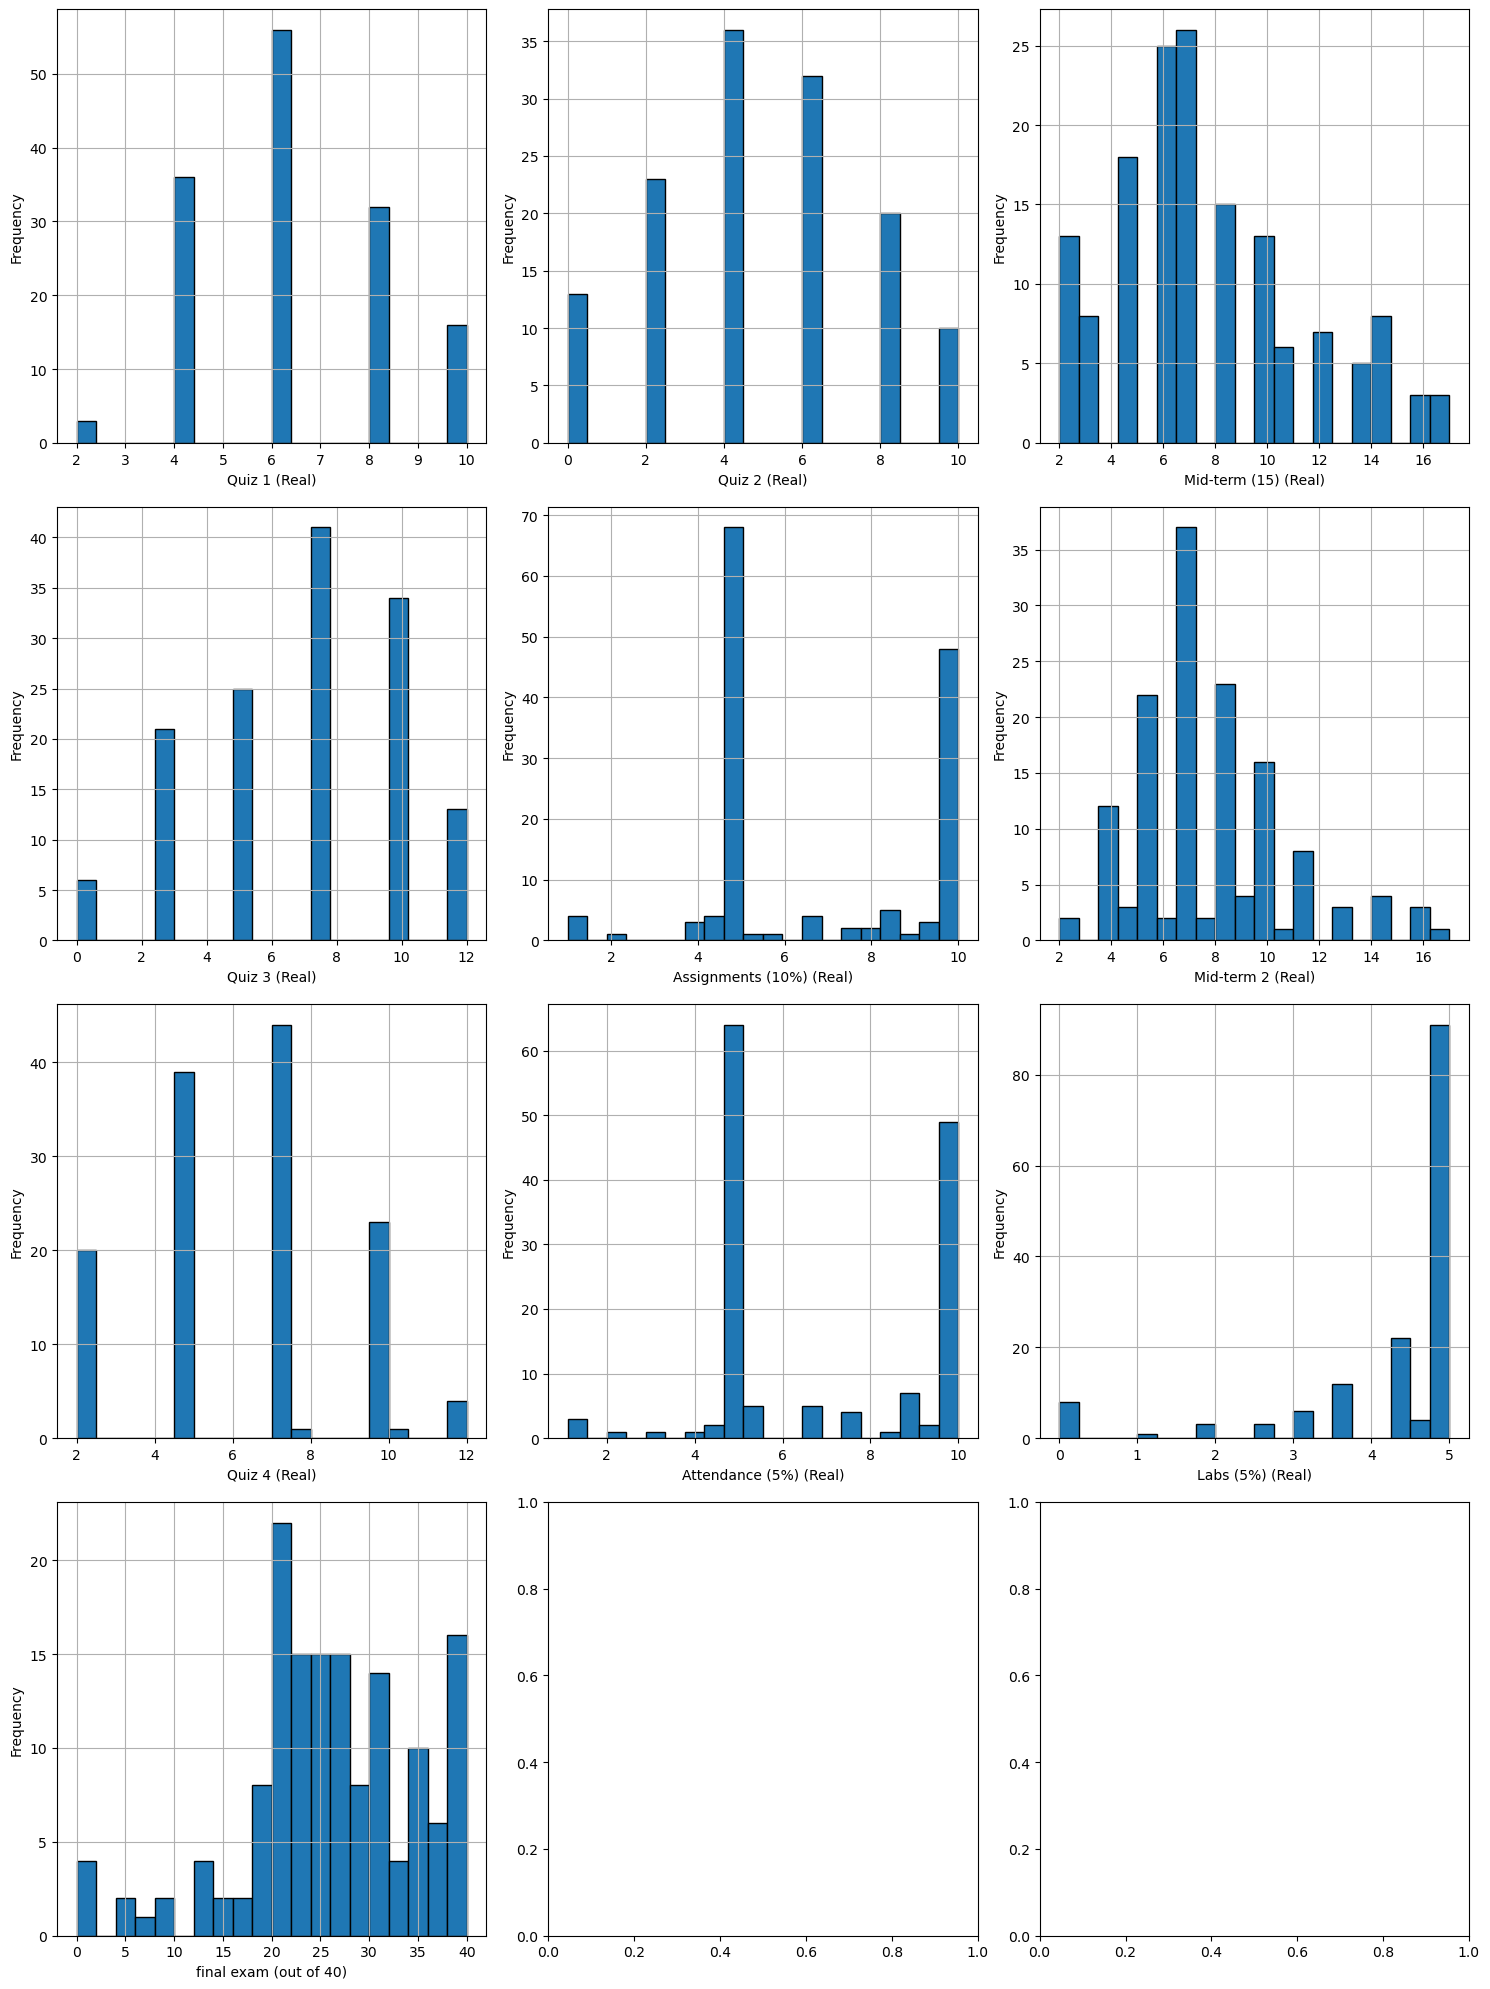

In [2]:
# Load the training dataset
train_data = pd.read_csv('/kaggle/input/ieeenu-cis-senior-members-grade-prediction-tool/PHY101 Train.csv')

# Preprocess the training data
train_data.replace('-', np.nan, inplace=True)  # Replace missing values represented as "-"

# Specify the columns to plot
columns_to_plot = ['Quiz 1 (Real)', 'Quiz 2 (Real)', 'Mid-term (15) (Real)', 'Quiz 3 (Real)',
                   'Assignments (10%) (Real)', 'Mid-term 2 (Real)', 'Quiz 4 (Real)',
                   'Attendance (5%) (Real)', 'Labs (5%) (Real)', 'final exam (out of 40)']

# Convert specified columns to numeric
train_data[columns_to_plot] = train_data[columns_to_plot].apply(pd.to_numeric, errors='coerce')

# Plot histograms for each specified column
num_columns = len(columns_to_plot)
num_rows = int(np.ceil(num_columns / 3))  # Three histograms per row

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    # Exclude NaN values from the plot
    data_to_plot = train_data[column].dropna()
    ax.hist(data_to_plot, bins=20, edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout()

plt.show()

# Data Preprocessing and Alignment 

In [4]:
# Load the training dataset
train_data = pd.read_csv('/kaggle/input/ieeenu-cis-senior-members-grade-prediction-tool/PHY101 Train.csv')

# Preprocess the training data
train_data.replace('-', np.nan, inplace=True)  # Replace missing values represented as "-"

# Separate the features and target variables
X_train = train_data.drop(['Sample number', 'total grades (out of 100)'], axis=1)
y_train = train_data['total grades (out of 100)']

# Load the test dataset
test_data = pd.read_csv('/kaggle/input/ieeenu-cis-senior-members-grade-prediction-tool/test.csv')

# Preprocess the test data
# Replace missing values represented as "-" with NaN in the specified columns
missing_value_columns = ['Mid-term (15) (Real)', 'Quiz 3 (Real)', 'Assignments (10%) (Real)', 'Mid-term 2 (Real)',
                         'Quiz 4 (Real)', 'Attendance (5%) (Real)', 'Labs (5%) (Real)', 'final exam (out of 40)']
test_data.replace('-', np.nan, inplace=True)

# Ensure that training data has the same columns in the same order as the test data
X_train = X_train.reindex(test_data.columns, axis=1)

# Print column names to identify the mismatch
print("X_train columns:", X_train.columns)
print("test_data columns:", test_data.columns)

X_train columns: Index(['Sample number', 'Quiz 1 (Real)', 'Quiz 2 (Real)',
       'Mid-term (15) (Real)', 'Quiz 3 (Real)', 'Assignments (10%) (Real)',
       'Mid-term 2 (Real)', 'Quiz 4 (Real)', 'Attendance (5%) (Real)',
       'Labs (5%) (Real)', 'final exam (out of 40)'],
      dtype='object')
test_data columns: Index(['Sample number', 'Quiz 1 (Real)', 'Quiz 2 (Real)',
       'Mid-term (15) (Real)', 'Quiz 3 (Real)', 'Assignments (10%) (Real)',
       'Mid-term 2 (Real)', 'Quiz 4 (Real)', 'Attendance (5%) (Real)',
       'Labs (5%) (Real)', 'final exam (out of 40)'],
      dtype='object')


# Training An RNN-based Multi-Output 

In [5]:
# Combine the training and test data for preprocessing
combined_data = pd.concat([X_train, test_data])

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
combined_data_imputed = pd.DataFrame(imputer.fit_transform(combined_data), columns=combined_data.columns)

# Separate the combined data back into training and test datasets
X_train = combined_data_imputed[:len(train_data)]
X_test = combined_data_imputed[len(train_data):]

# Prepare y_train for the multi-output format
y_train_multioutput = X_train[missing_value_columns]

# Remove the columns with missing values from X_train as we are using them as target variables
X_train.drop(missing_value_columns, axis=1, inplace=True)

# Build the RNN model for multi-output prediction
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))  # Reshape for LSTM input (timesteps, features)
model.add(Dense(len(missing_value_columns)))  # Output layer for multiple outputs

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Reshape X_train and X_test for LSTM input (selecting only the relevant columns)
X_train_reshaped = X_train.iloc[:, :3].values.reshape(X_train.shape[0], 3, 1)
X_test_reshaped = X_test.iloc[:, :3].values.reshape(X_test.shape[0], 3, 1)

# Split the training data into training and validation sets for evaluation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_reshaped, y_train_multioutput, test_size=0.2, random_state=42)

# Train the RNN model on the training data split
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Make predictions on the test data
test_predictions = model.predict(X_test_reshaped)

# Update the missing values in the test_data DataFrame with the predicted values
for i, column in enumerate(missing_value_columns):
    test_data[column].fillna(pd.Series(test_predictions[:, i]), inplace=True)

# Save the updated test dataset to a new CSV file
test_data.to_csv('/kaggle/working/predicted_test.csv', index=False)

# Print the updated test dataset with the predicted values
print(test_data)

/tmp/ipykernel_32/1775116957.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(missing_value_columns, axis=1, inplace=True)


Epoch 1/100
3/3 [==============================] - 3s 282ms/step - loss: 143.6140 - val_loss: 118.9737
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 140.8983 - val_loss: 116.5807
Epoch 3/100
3/3 [==============================] - 0s 27ms/step - loss: 138.3539 - val_loss: 114.2536
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 135.8128 - val_loss: 111.9572
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 133.2591 - val_loss: 109.6367
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 130.7258 - val_loss: 107.2403
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 128.1065 - val_loss: 104.7403
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 125.3144 - val_loss: 102.1140
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 122.3820 - val_loss: 99.3298
Epoch 10/100
3/3 [==============================] - 0s 19ms/step - loss: 119.2900 

# Inference Time Measurement

In [6]:
# Make predictions on the test data and measure the inference time
start_time = time.time()  # Start time for inference time calculation
test_predictions = model.predict(X_test_reshaped)
end_time = time.time()  # End time for inference time calculation

inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.2f} seconds")

4/4 [==============================] - 0s 2ms/step
Inference Time: 0.08 seconds


# Learning Curve

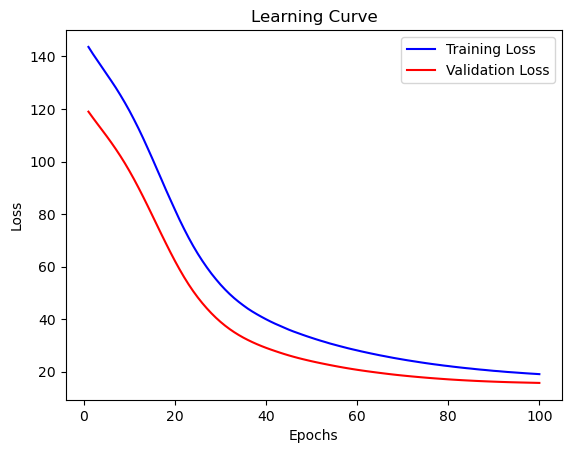

In [7]:
# Plot the learning curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()